In [ ]:
# in this notebook, we load two cluster assignments, create dictionaries using the shared examples only based on their keys, and measure their similarities.

In [183]:
# let's load a few important packages for checking the cluster similarities
import numpy as np
import pandas as pd
import os
import sys
import json
from collections import Counter
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples

In [184]:
# let's load the target/ground-truth cluster assignments. it's in `root_id_type_dict.pkl` file.
import pickle
root_id_type_dict = pickle.load(open('root_id_type_dict.pkl', 'rb'))

In [ ]:
# let's load the estimated cluster assignments from `cluster_assignment_dict.npy`
cluster_assignment_dict = np.load('pca_cluster_assignment_dict.npy', allow_pickle=True).item()
# cluster_assignment_dict = np.load('cluster_assignment_dict.npy', allow_pickle=True).item()

In [198]:
# first, let's create a dictionary of the keys of `root_id_type_dict` mapped to integer indices.
root_id_type_dict_keys = list(root_id_type_dict.keys())
root_id_type_dict_keys_dict = {root_id_type_dict_keys[i]: i for i in range(len(root_id_type_dict_keys))}

In [199]:
shared_root_ids = list(set(root_id_type_dict.keys()).intersection(set(cluster_assignment_dict.keys())))

In [200]:
len(shared_root_ids)

46479

In [201]:
# create a cluster assignment array using the keys of `root_id_type_dict`.
# to do so, first, we should convert string-based values of `root_id_type_dict` into integer-based values.
root_id_type_dict_cluster_strings = list(set(root_id_type_dict.values()))
root_id_type_dict_values_int = dict([(cluster_string, cid) 
                                     for cid, cluster_string 
                                     in enumerate(root_id_type_dict_cluster_strings)])
print(f'there are {len(root_id_type_dict_values_int)} unique cluster assignments in the ground-truth data.')

# create a cluster assignment array using the keys of `root_id_type_dict`.
# since we use python3, we assume `dict` preserves the order of the items.
ground_truth_assignment = np.array([root_id_type_dict_values_int[root_id_type_dict[key]] 
                                         for key in shared_root_ids])
print(f'the shape of the ground-truth cluster assignment is {ground_truth_assignment.shape}.')

there are 729 unique cluster assignments in the ground-truth data.
the shape of the ground-truth cluster assignment is (46479,).


In [202]:
# now we do it for `cluster_assignment_dict`.
# first, we should convert values of `cluster_assignment_dict` into integer-based values.
cluster_assignment_dict_cluster_strings = list(set(cluster_assignment_dict.values()))
cluster_assignment_dict_values_int = dict([(cluster_string, cid) 
                                           for cid, cluster_string 
                                           in enumerate(cluster_assignment_dict_cluster_strings)])
print(f'there are {len(cluster_assignment_dict_values_int)} unique cluster assignments in the estimated data.')

# create a cluster assignment array using the keys of `cluster_assignment_dict`.
target_assignment = np.array([cluster_assignment_dict_values_int[cluster_assignment_dict[key]]
                              for key in shared_root_ids])
print(f'the shape of the target cluster assignment is {target_assignment.shape}.')


there are 729 unique cluster assignments in the estimated data.
the shape of the target cluster assignment is (46479,).


In [203]:
# create a random assignment by randomly permuting `target_assignment`
random_assignment = np.random.permutation(target_assignment)

In [204]:
len(target_assignment), len(ground_truth_assignment)

(46479, 46479)

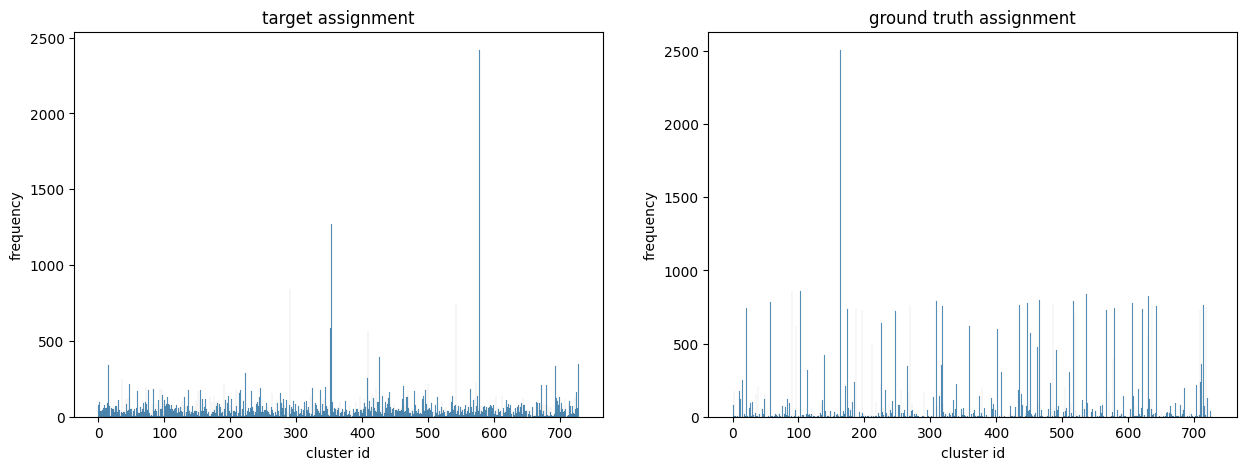

In [205]:
# draw a histogram of `target_assignment` and `ground_truth_assignment` to see the distribution of the clusters.
import matplotlib.pyplot as plt
import seaborn as sns

# draw a histogram of `target_assignment`
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(target_assignment, bins=len(set(target_assignment)))
plt.xlabel('cluster id')
plt.ylabel('frequency')
plt.title('target assignment')

# draw a histogram of `ground_truth_assignment`
plt.subplot(1, 2, 2)
sns.histplot(ground_truth_assignment, bins=len(set(ground_truth_assignment)))
plt.xlabel('cluster id')
plt.ylabel('frequency')
plt.title('ground truth assignment')

plt.show()



In [206]:
def confusion_matrix(X, Y):
    assert len(X) == len(Y)

    unique_x = np.unique(X)
    unique_y = np.unique(Y)

    x_dict = dict([(unique_x[i], i) for i in range(len(unique_x))])
    y_dict = dict([(unique_y[i], i) for i in range(len(unique_y))])

    confusion_matrix = np.zeros((len(unique_x), len(unique_y)))

    for i in range(len(X)):
        confusion_matrix[x_dict[X[i]], y_dict[Y[i]]] += 1

    return confusion_matrix

In [207]:
confusion_matrix_value = confusion_matrix(ground_truth_assignment, target_assignment)
confusion_matrix_value.max(), confusion_matrix_value.std(), confusion_matrix_value.min()

(np.float64(1034.0), np.float64(1.818524223202326), np.float64(0.0))

Cost: 2868.0
Cost: 1139.0


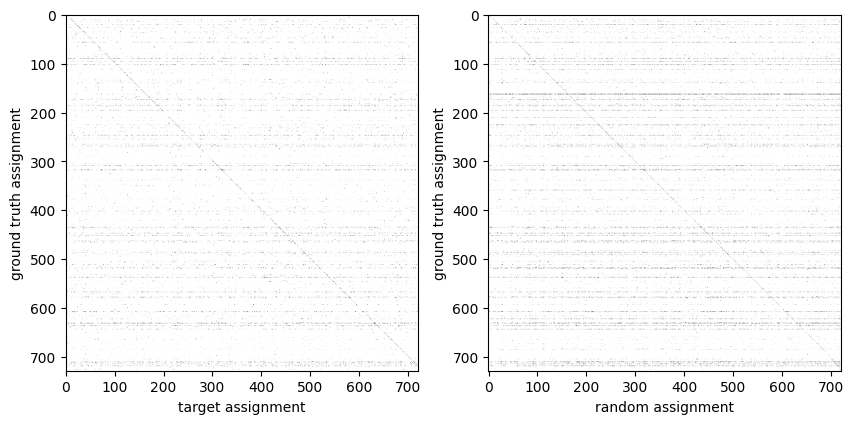

In [211]:
from scipy.optimize import linear_sum_assignment

plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
# let's plot a confusion matrix between `target_assignment` and `ground_truth_assignment`.
confusion_matrix_value = confusion_matrix(ground_truth_assignment, target_assignment)

# Align clusters using the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(confusion_matrix_value, maximize=True)
print(f"Cost: {confusion_matrix_value[row_ind, col_ind].sum()}")

# Reorder columns of the confusion matrix to align clusters
aligned_confusion_matrix = confusion_matrix_value[:, col_ind]

# use imshow with grayscale
plt.imshow((1-aligned_confusion_matrix/aligned_confusion_matrix.max(0, keepdims=True)) * 255, cmap='gray')

plt.xlabel('target assignment')
plt.ylabel('ground truth assignment')

plt.subplot(1,2,2)
# let's plot a confusion matrix between `target_assignment` and `ground_truth_assignment`.
confusion_matrix_value = confusion_matrix(ground_truth_assignment, random_assignment)

# Align clusters using the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(confusion_matrix_value, maximize=True)
print(f"Cost: {confusion_matrix_value[row_ind, col_ind].sum()}")

# Reorder columns of the confusion matrix to align clusters
aligned_confusion_matrix = confusion_matrix_value[:, col_ind]

# normalize the reordered confusion matrix
# reordered_confusion_matrix = reordered_confusion_matrix / reordered_confusion_matrix.max(axis=1, keepdims=True)

# use imshow with grayscale
plt.imshow((1-aligned_confusion_matrix/aligned_confusion_matrix.max(0, keepdims=True)) * 255, cmap='gray')

plt.xlabel('random assignment')
plt.ylabel('ground truth assignment')

plt.show()

In [99]:
confusion_matrix_value.shape

(729, 64)